<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>Тема 4. Линейные модели классификации и регрессии
## <center>Часть 2. Логистическая регрессия и метод максимального правдоподобия 

### Линейный классификатор

Основная идея линейного классификатора заключается в том, что признаковое пространство может быть разделено гиперплоскостью на две полуплоскости, в каждой из которых прогнозируется одно из двух значений целевого класса. 
Если это можно сделать без ошибок, то обучающая выборка называется *линейно разделимой*.

<img src="../../img/logit.png">

Мы уже знакомы с линейной регрессией и методом наименьших квадратов. Рассмотрим задачу бинарной классификации, причем метки целевого класса обозначим "+1" (положительные примеры) и "-1" (отрицательные примеры).
Один из самых простых линейных классификаторов получается на основе регрессии вот таким образом:

$$a(\vec{x}) = sign(\vec{w}^Tx),$$

где
 - $\vec{x}$ – вектор признаков примера (вместе с единицей);
 - $\vec{w}$ – веса в линейной модели (вместе со смещением $w_0$);
 - $sign(\bullet)$ – функция "сигнум", возвращающая знак своего аргумента;
 - $a(\vec{x})$ – ответ классификатора на примере $\vec{x}$.



### Логистическая регрессия как линейный классификатор

Логистическая регрессия является частным случаем линейного классификатора, но она обладает хорошим "умением" – прогнозировать вероятность $p_+$ отнесения примера $\vec{x_i}$ к классу "+":
$$p_+ = P\left(y_i = 1 \mid \vec{x_i}, \vec{w}\right) $$

Прогнозирование не просто ответа ("+1" или "-1"), а именно *вероятности* отнесения к классу "+1" во многих задачах является очень важным бизнес-требованием. Например, в задаче кредитного скоринга, где традиционно применяется логистическая регрессия, часто прогнозируют вероятность невозврата кредита ($p_+$). Клиентов, обратившихся за кредитом, сортируют по этой предсказанной вероятности (по убыванию), и получается скоркарта — по сути, рейтинг клиентов от плохих к хорошим. Ниже приведен игрушечный пример такой скоркарты. 
    <img src='../../img/toy_scorecard.png' width=60%>

Банк выбирает для себя порог $p_*$ предсказанной вероятности невозврата кредита (на картинке – $0.15$) и начиная с этого значения уже не выдает кредит. Более того, можно умножить предсказнную вероятность на выданную сумму и получить матожидание потерь с клиента, что тоже будет хорошей бизнес-метрикой (*Далее в комментариях специалисты по скорингу могут поправить, но главная суть примерно такая*).

Итак, мы хотим прогнозировать вероятность $p_+ \in [0,1]$, а пока умеем строить линейный прогноз с помощью МНК: $b(\vec{x}) = \vec{w}^T \vec{x} \in \mathbb{R}$. Каким образом преобразовать полученное значение в вероятность, пределы которой – [0, 1]? Очевидно, для этого нужна некоторая функция $f: \mathbb{R} \rightarrow [0,1].$ В модели логистической регрессии для этого берется конкретная функция: $\sigma(z) = \frac{1}{1 + \exp^{-z}}$. И сейчас разберемся, каковы для этого предпосылки. 

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def sigma(z):
    return 1. / (1 + np.exp(-z))

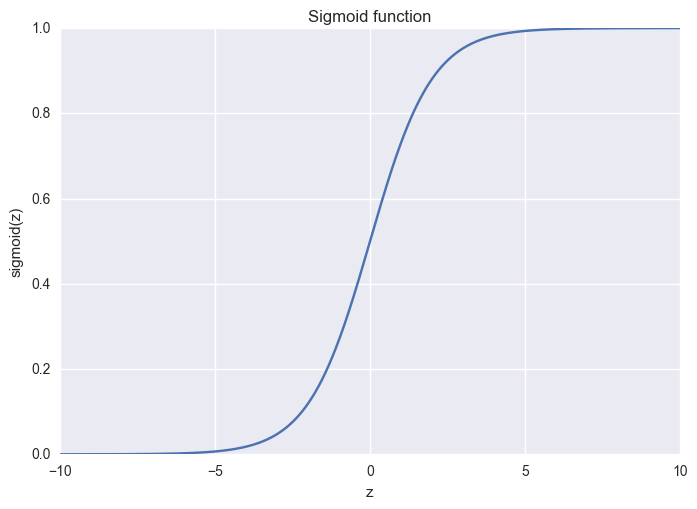

In [3]:
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, [sigma(x) for x in xx]);
plt.xlabel('z');
plt.ylabel('sigmoid(z)')
plt.title('Sigmoid function');

Обозначим $P(X)$ вероятностью происходящего события $X$. Тогда отношение вероятностей $OR(X)$ определяется из $\frac{P(X)}{1-P(X)}$, а это — отношение вероятностей того, произойдет ли событие или не произойдет. Очевидно, что вероятность и отношение шансов содержат одинаковую информацию. Но в то время как $P(X)$ находится в пределах от 0 до 1, $OR(X)$ находится в пределах от 0 до $\infty$.

Если вычислить логарифм $OR(X)$ (то есть называется логарифм шансов, или логарифм отношения вероятностей), то легко заметить, что $\log{OR(X)} \in \mathbb{R}$. Его то мы и будем прогнозировать с помощью МНК.

Посмотрим, как логистическая регрессия будет делать прогноз $p_+ = P\left(y_i = 1 \mid \vec{x_i}, \vec{w}\right)$ (пока считаем, что веса $\vec{w}$ мы как-то получили (т.е. обучили модель), далее разберемся, как именно). 

**Шаг 1.** Вычислить значение $w_{0}+w_{1}x_1 + w_{2}x_2 + ... = \vec{w}^T\vec{x}$. (уравнение $\vec{w}^T\vec{x} = 0$ задает гиперплоскость, разделяющую примеры на 2 класса);


**Шаг 2.** Вычислить логарифм отношения шансов: $ \log(OR_{+}) =  \vec{w}^T\vec{x}$.

**Шаг 3.** Имея прогноз шансов на отнесение к классу "+" – $OR_{+}$, вычислить $p_{+}$ с помощью простой зависимости:

$\Large p_{+} = \frac{OR_{+}}{1 + OR_{+}} = \frac{\exp^{\vec{w}^T\vec{x}}}{1 + \exp^{\vec{w}^T\vec{x}}} =  \frac{1}{1 + \exp^{-\vec{w}^T\vec{x}}} = \sigma(\vec{w}^T\vec{x})$


В правой части мы получили как раз сигмоид-функцию.

Итак, логистическая регрессия прогнозирует вероятность отнесения примера к классу "+" (при условии, что мы знаем его признаки и веса модели) как сигмоид-преобразование линейной комбинации вектора весов модели и вектора признаков примера:

$$p_+(x_i) = P\left(y_i = 1 \mid \vec{x_i}, \vec{w}\right) = \sigma(\vec{w}^T\vec{x_i}). $$

Следующий вопрос: как модель обучается. Тут мы опять обращаемся к приницпу максимального правдоподобия.

### Принцип максимального правдоподобия и логистическая регрессия
Теперь посмотрим, как из принципа максимального правдоподобия получается оптимизационная задача, которую решает логистическая регрессия, а именно, – минимизация *логистической* функции потерь. 
Только что мы увидели, что логистическая регрессия моделирует вероятность отнесения примера к классу "+" как 

$$p_+(\vec{x_i}) = P\left(y_i = 1 \mid \vec{x_i}, \vec{w}\right) = \sigma(\vec{w}^T\vec{x_i})$$

Тогда для класса "-" аналогичная вероятность:
$$p_-(\vec{x_i})  = P\left(y_i = -1 \mid \vec{x_i}, \vec{w}\right)  = 1 - \sigma(\vec{w}^T\vec{x_i}) = \sigma(-\vec{w}^T\vec{x_i}) $$

Оба этих выражения можно ловко объединить в одно (следите за моими руками – не обманывают ли вас):

$$P\left(y = y_i \mid \vec{x_i}, \vec{w}\right) = \sigma(y_i\vec{w}^T\vec{x_i})$$

Выражение $M(\vec{x_i}) = y_i\vec{w}^T\vec{x_i}$ называется *отступом* (*margin*) классификации на объекте $\vec{x_i}$ (не путать с зазором (тоже margin), про который чаще всего говорят в контексте SVM). Если он неотрицателен, модель не ошибается на объекте $\vec{x_i}$, если же отрицателен – значит, класс для $\vec{x_i}$  спрогнозирован неправильно. 
Заметим, что отступ определен для объектов именно обучающей выборки, для которых известны реальные метки целевого класса $y_i$.

Чтобы понять, почему это мы сделали такие выводы, обратимся к геометрической интерпретации линейного классификатора. Подробно про это можно почитать в материалах Евгения Соколова – [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem09_linear.pdf). 

Рекомендую решить почти классическую задачу из начального курса линейной алгебры: найти расстояние от точки с радиус-вектором $\vec{x_A}$ до плоскости, которая задается уравнением $\vec{w}^T\vec{x} = 0.$


<spoiler title='Ответ'>
$\rho(\vec{x_A}, \vec{w}^T\vec{x} = 0) = \frac{\vec{w}^T\vec{x_A}}{||\vec{w}||}$
</spoiler>

<img src = '../../img/simple_linal_task.png' width=60%>

Когда получим (или посмотрим) ответ, то поймем, что чем больше по модулю выражение $\vec{w}^T\vec{x_i}$, тем дальше точка $\vec{x_i}$ находится от плоскости $\vec{w}^T\vec{x} = 0.$

Значит, выражение $M(\vec{x_i}) = y_i\vec{w}^T\vec{x_i}$ – это своего рода "уверенность" модели в классификации объекта $\vec{x_i}$: 

- если отступ большой (по модулю) и положительный, это значит, что метка класса поставлена правильно, а объект находится далеко от разделяюящей гиперплоскости (такой объект классифицируется уверенно). На рисунке – $x_3$.
- если отступ большой (по модулю) и отрицательный, значит метка класса поставлена неправильно, а объект находится далеко от разделюящей гиперплоскости (скорее всего такой объект – аномалия, например, его метка в обучающей выборке поставлена неправильно). На рисунке – $x_1$.
- если отступ малый (по модулю), то объект находится близко к разделюящей гиперплоскости, а  знак отступа определяет, правильно ли объект классифицирован.  На рисунке – $x_2$ и $x_4$.

<img src = '../../img/margin.png' width=60%>

Теперь распишем правдоподобие выборки, а именно, вероятность наблюдать данный вектор $\vec{y}$ у выборки $X$. Делаем сильное предположение: объекты приходят независимо, из одного распределения (*i.i.d.*). Тогда

$$P\left(\vec{y} \mid X, \vec{w}\right) = \prod_{i=1}^{\ell} P\left(y = y_i \mid \vec{x_i}, \vec{w}\right),$$

где $\ell$ – длина выборки $X$ (число строк).

Как водится, возьмем логарифм данного выражения (сумму оптимизировать намного проще, чем произведение):

$$\log P\left(\vec{y} \mid X, \vec{w}\right) = \log \prod_{i=1}^{\ell} P\left(y = y_i \mid \vec{x_i}, \vec{w}\right) = \log \prod_{i=1}^{\ell} \sigma(y_i\vec{w}^T\vec{x_i})   = $$

$$ = \sum_{i=1}^{\ell} \log \sigma(y_i\vec{w}^T\vec{x_i}) = \sum_{i=1}^{\ell} \log \frac{1}{1 + \exp^{-y_i\vec{w}^T\vec{x_i}}} = - \sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\vec{w}^T\vec{x_i}})$$

То есть в даном случае принцип максимизации правдоподобия приводит к минимизации выражения 

$$\mathcal{L_{log}} (X, \vec{y}, \vec{w}) = \sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\vec{w}^T\vec{x_i}}).$$

Это *логистическая* функция потерь, просуммированная по всем объектам обучающей выборки.

Посмотрим на новую фунцию как на функцию от отступа: $L(M) = \log (1 + \exp^{-M})$. Нарисуем ее график, а также график 1/0 функциий потерь (*zero-one loss*), которая просто штрафует модель на 1 за ошибку на каждом объекте (отступ отрицательный): $L_{1/0}(M) = [M < 0]$.

<img src = '../../img/logloss_margin.png' width=60%>

Картинка отражает общую идею, что в задаче классификации, не умея напрямую минимизировать число ошибок (по крайней мере, градиентными методами это не сделать – производная 1/0 функциий потерь в нуле обращается в бесконечность), мы минимизируем некоторую ее верхнюю оценку. В данном случае это логистическая функция потерь (где логарифм двоичный, но это не принципиально), и справедливо 

$$\mathcal{L_{1/0}} (X, \vec{y}, \vec{w}) = \sum_{i=1}^{\ell} [M(\vec{x_i}) < 0] \leq \sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\vec{w}^T\vec{x_i}}) = \mathcal{L_{log}} (X, \vec{y}, \vec{w}), $$

где $\mathcal{L_{1/0}} (X, \vec{y}, \vec{w})$ – попросту число ошибок логистической регрессии с весами $\vec{w}$ на выборке $(X, \vec{y})$.

То есть уменьшая верхнюю оценку $\mathcal{L_{log}}$ на число ошибок классификации, мы таким образом надеемся уменьшить и само число ошибок.

### L2-регуляризация логистической функции потерь

$L2-регуляризация$ логистической регрессии устроена почти так же, как и в случае с гребневой (Ridge регрессией). Вместо функционала $\mathcal{L_{log}} (X, \vec{y}, \vec{w})$ минимизируется следующий:

$$J(X, \vec{y}, \vec{w}) = \mathcal{L_{log}} (X, \vec{y}, \vec{w}) + \lambda |\vec{w}|^2$$

В случае логистической регрессии принято введение обратного коэффициента регуляризации $C = \frac{1}{\lambda}$. И тогда решением задачи будет

$$\hat{w}  = \arg \min_{\vec{w}} J(X, \vec{y}, \vec{w}) =  \arg \min_{\vec{w}}\ (C\sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\vec{w}^T\vec{x_i}})+ |\vec{w}|^2)$$ 

Далее рассмотрим пример, позволяющий интуитивно понять один из смыслов регуляризации. 